# Custom Bench Stats Visualization and Analysis

We run Minh custom Benchmark using TCmalloc mallocator. Benchmarking process is divided into multiple phases, each is either classified as up phase or down phase. Each benchmark phase has multiple producers, each allocates x objects and add them to a queue, and consumers deallocating from that queue. Up phase has producers allocating obejcts at a higher rate than consumers deallocating the objects. Below are the configurations of the benchmark and tcmalloc.
* benchmark
    * Number of producers = 1000
    * Number of consumers = 1000
    * Number of objects to be allocated by each producer thread = 40
    * Random sleep time of a producer in up phase is in [1, 10] interval.
    * Random sleep time of a producer in down phase is in [1, 50] interval
    * Random sleep time of a consumer in all phases is in [2, 20] interval
* tcmalloc
    * Drain CPU cache when there is a hugepage with live_size == 0 && cpu_cache_idle_size != 0

All configurations that are specific to each experiment are described in each section below.

## Set up

In [91]:
import os
import re
import sys
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from natsort import natsorted

In [92]:
class GraphHugePageStats:
    def __init__(self, bench_directory, test_suite, test, release_rates, profile, drain_check_cycle):
        self.bench_directory = bench_directory
        self.test_suite = test_suite
        self.test = test
        self.release_rates = release_rates
        self.profile = profile
        self.drain_check_cycle = drain_check_cycle

        self.set_up_directories()
        stats_directory = os.path.join(bench_directory, "stats_storage", profile_name, test, release_rates, drain_check_cycle)
        smem_directory = os.path.join(bench_directory, "smem", profile_name, test, release_rates, drain_check_cycle)
        self.read_files(stats_directory, smem_directory)
        # self.deallocate_log = log
        self.PIC_DIR = os.path.join(bench_directory, "pic", profile)
        self.pic_name = profile + "-" + test + "-" + release_rates + "-" + drain_check_cycle
        self.test_name = test

    def set_up_directories(self):
        self.pic_dir = self.bench_directory + "pic/" + profile_name + "/"
        try:
            os.mkdir(self.bench_directory + "pic/")
        except FileExistsError:
            pass

        try:
            os.mkdir(self.pic_dir)
        except FileExistsError:
            pass

    def read_files(self, stats_directory, smem_directory):
        print(stats_directory)
        dict_list = list()

        totalStrandedPage = list()
        totalHugePageRequested = list()
        totalHugePageInUse = list()
        totalHugePageFree = list()
        percentage = list()

        current_hp_in_cache = list()
        current_capacity = list()

        file_list = [os.path.join(stats_directory, f) for f in os.listdir(stats_directory)]
        # print(file_list)
        file_list.sort()
        file_list.sort(key=len)
        # Process files
        for file in file_list:
            hp_dict = dict()
            f = open(file, "r")
            read = f.read()

            # Process per-hugepage stats
            per_hugepage_pattern = "HugePage at addr .+\n\tLive size:\s*\d+\sbytes\n\tCPU Cache Idle size:\s*\d+\sbytes\n\tCentral Cache Idle size:\s*\d+\sbytes\n\tFree size:\s*\d+\sbytes"
            hp_text_list = re.findall(per_hugepage_pattern, read)
            for hp_text in hp_text_list:
                hp_text_lines = hp_text.split("\n")
                addr = hp_text_lines[0].split()[-1]
                live = int(hp_text_lines[1].split()[-2])
                cpu_cache_idle = int(hp_text_lines[2].split()[-2])
                central_cache_idle = int(hp_text_lines[3].split()[-2])
                # hp_dict[addr] = (live, cpu_cache_idle)
                if live != 0 or cpu_cache_idle != 0:
                    hp_dict[addr] = (live, cpu_cache_idle, central_cache_idle)
            dict_list.append(hp_dict)

            # Process stranded page stats
            num_hp_stranded_pattern = "Total\s*\d+ Hugepage\(s\) stranded in all cpu caches."
            text = re.findall(num_hp_stranded_pattern, read)[0]
            num_stranded_page = int(text.split()[1])
            totalStrandedPage.append(num_stranded_page)

            hp_usage_pattern = "HugeAllocator: \d+ requested - \d+ in use = \d+ hugepages free"
            text = re.findall(hp_usage_pattern, read)[0]
            num_requested_page = int(text.split()[1])
            num_inuse_page = int(text.split()[4])
            num_free_page = int(text.split()[8])

            totalHugePageRequested.append(num_requested_page)
            totalHugePageInUse.append(num_inuse_page)
            totalHugePageFree.append(num_free_page)

            percentage.append(num_stranded_page / num_requested_page * 100)

            # Process huge cache stats
            hugecache_pattern = "HugeCache: \d+ \/\ \d+ hugepages cached \/\ cache limit \(\d+.\d+ hit rate, \d+.\d+ overflow rate\)"
            text = re.findall(hugecache_pattern, read)[0]
            words = text.split()
            current_hp_in_cache.append(int(words[1]))
            current_capacity.append(int(words[3]))

        file_list = [os.path.join(smem_directory, f) for f in os.listdir(smem_directory)]
        latest_file = max(file_list, key=os.path.getctime)

        f = open(latest_file, "r")
        f.readline()
        self.memo = f.readline()
        self.date = f.readline()
        columns = f.readline().split()[2:]
        data = list()

        for line in f:
            data.append(int(x) / 1000 for x in line.split()[2:])

        self.mem_df = pd.DataFrame(data=data, columns=columns)
        self.mem_df = self.mem_df.dropna()
        self.mem_df = self.mem_df.astype({"RSS":np.int, "PSS":np.int, "USS":np.int})




        self.dict_list = dict_list

        self.totalStrandedPage = totalStrandedPage
        self.totalHugePageRequested = totalHugePageRequested
        self.totalHugePageInUse = totalHugePageInUse
        self.totalHugePageFree = totalHugePageFree
        self.percentage = percentage

        self.current_hp_in_cache = current_hp_in_cache
        self.current_capacity = current_capacity

    
    def graph_histogram(self, timestamp=0):
        uselessness_list = [(cpu+1)/(live+1) for (live, cpu, central) in self.dict_list[timestamp].values() if (cpu+1)/(live+1) != 0]
        # uselessness_list = [(cpu+1)/(live+1) for (live, cpu) in self.dict_list[timestamp].values()]
        if 0 in uselessness_list: print("There is 0")
        n, bins, patches = plt.hist(x=uselessness_list, bins=100, color='#0504aa')
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('CPU Cache Idle : Live')
        plt.ylabel('Frequency')
        plt.title('Histogram at time stamp' + str(timestamp))
        # maxfreq = n.max()
        # Set a clean upper y-axis limit.
        # plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
        plt.show()

    def graph_memory_usage(self,):
        plt.plot(self.mem_df.RSS, label="RSS")
        plt.plot(self.mem_df.PSS, label="PSS")
        plt.plot(self.mem_df.USS, label="USS")
        plt.legend()
        plt.xlabel("time (s)")
        plt.ylabel("Mem usage (MB)")
        plt.title(self.date + " " + self.test + " " + self.memo)
        # if self.deallocate_log:
        #     for coor in self.deallocate_log:
        #         plt.axvline(x=coor, c="skyblue", ls='--')
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.pic_name  + '-Mem-Usage.png'), dpi = 100)
        plt.show()

    def graph_mean_std_idle_live_ratio_timeseries(self):
        x = list(range(len(self.dict_list)))
        means = list()
        stds = list()
        for hp_dict in self.dict_list:
            uselessness_list = [(cpu+1)/(live+1) for (live, cpu, central) in hp_dict.values()]
            means.append(np.mean(uselessness_list))
            stds.append(np.std(uselessness_list))
        # if self.deallocate_log:
        #     for coor in self.deallocate_log:
        #         plt.axvline(x=coor, c="skyblue", ls='--')
        #         pass
        plt.errorbar(x=x, y=means, yerr=stds, ecolor="r")
        print("Mean of means", np.mean(means))
        plt.xlabel('Time (s)')
        plt.ylabel('Mean of CPU Cache Idle : Live')
        plt.title(self.pic_name)
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.pic_name  + '-Mean CPU Cache Idle.png'), dpi = 100)
        plt.show()
    
    def graph_mean_median_idle_live_ratio_timeseries(self):
        x = list(range(len(self.dict_list)))
        means = list()
        medians = list()
        for hp_dict in self.dict_list:
            uselessness_list = [(cpu+1)/(live+1) for (live, cpu, central) in hp_dict.values()]
            means.append(np.mean(uselessness_list))
            medians.append(np.median(uselessness_list))
        # if self.deallocate_log:
        #     for coor in self.deallocate_log:
        #         plt.axvline(x=coor, c="skyblue", ls='--')
        #         pass
        plt.plot(x, means,label="mean")
        plt.plot(x, medians,label="median")
        plt.xlabel('Time (s)')
        plt.ylabel('Mean and Median of CPU Cache Idle : Live')
        plt.title(self.pic_name)
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.pic_name  + '-Mean Median CPU Cache Idle.png'), dpi = 100)
        plt.show()

    def graph_mean_std_idle_percentage_timeseries(self):
        x = list(range(len(self.dict_list)))
        means = list()
        stds = list()
        for hp_dict in self.dict_list:
            uselessness_list = [(cpu)/(live+cpu+central) for (live, cpu, central) in hp_dict.values()]
            means.append(np.mean(uselessness_list))
            stds.append(np.std(uselessness_list))
        # if self.deallocate_log:
        #     for coor in self.deallocate_log:
        #         plt.axvline(x=coor, c="skyblue", ls='--')
        #         pass
        plt.errorbar(x=x, y=means, yerr=stds, ecolor="r")
        print("Mean of means", np.mean(means))
        plt.xlabel('Time (s)')
        plt.ylabel('Mean and STD of percentage of CPU Idle to CPU Idle+Live')
        plt.title(self.pic_name)
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.pic_name  + '-Mean CPU Cache Idle.png'), dpi = 100)
        plt.show()
    
    def graph_mean_median_idle_percentage_timeseries(self):
        x = list(range(len(self.dict_list)))
        means = list()
        medians = list()
        for hp_dict in self.dict_list:
            uselessness_list = [(cpu)/(live+cpu) for (live, cpu, central) in hp_dict.values()]
            means.append(np.mean(uselessness_list))
            medians.append(np.median(uselessness_list))
        # if self.deallocate_log:
        #     for coor in self.deallocate_log:
        #         plt.axvline(x=coor, c="skyblue", ls='--')
        #         pass
        plt.plot(x, means,label="mean")
        plt.plot(x, medians,label="median")
        plt.xlabel('Time (s)')
        plt.ylabel('Mean and Median of percentage of CPU Idle to CPU Idle+Live')
        plt.title(self.pic_name)
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.pic_name  + '-Mean Median CPU Cache Idle.png'), dpi = 100)
        plt.show()

    def plot_stranded_percentage(self):
        textstr = '\n'.join((f"Max Requested HP {max(self.totalHugePageRequested)}",
                            f"Min Requested HP {min(self.totalHugePageRequested)}",
                            f"Max Stranded {max(self.totalStrandedPage)}",
                            f"Min Stranded {min(self.totalStrandedPage)}"))
        plt.plot(self.percentage, label="Percentage")
        plt.xlabel("time (s)")
        plt.ylabel("%")
        plt.title("% Huge Page Stranded in " + self.test_name)

        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.text(0.8, 0.9, textstr, fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.5))
        fig.savefig(os.path.join(self.PIC_DIR, self.test_name + '-HP-Stranded.png'), dpi = 100)
        plt.show()

    def plot_hugepage_usage(self):
        plt.plot(self.totalStrandedPage, label="Stranded Page")
        plt.plot(self.totalHugePageRequested, label="Requested")
        plt.plot(self.totalHugePageInUse, label="In Use")
        plt.plot(self.totalHugePageFree, label="Free")
        plt.legend()
        plt.xlabel("time (s)")
        plt.ylabel("num(s) page")
        plt.title("Huge Page Usage in " + self.test_name)
        
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.test_name + '-HP-Usage.png'), dpi = 100)
        plt.show()

    def plot_huge_cache(self):
        plt.plot(self.current_hp_in_cache, label="Available")
        plt.plot(self.current_capacity, label="Capacity")
        plt.legend()
        plt.xlabel("time (s)")
        plt.ylabel("num(s) page")
        plt.title("Huge Pages in Huge Cache - " + self.test_name)
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(os.path.join(self.PIC_DIR, self.test_name + '-HP-Usage.png'), dpi = 100)
        plt.show()

## Minh Custom Bench

### Beta - 0MB - 0s
* Profile: Beta
* Release rate: 0MB
* We do not drain the CPU Cache

In [93]:
test_suite="minh-custom-bench"
tests=["Producer-Consumer"]
release_rates=["0MB"]
directory="/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/"
profile_name="Beta"
drain_check_cycle="0s"

In [94]:
g = GraphHugePageStats(directory, test_suite=test_suite, test=tests[0], release_rates=release_rates[0],
                       profile=profile_name, drain_check_cycle=drain_check_cycle)

/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/stats_storage/Beta/Producer-Consumer/0MB/0s


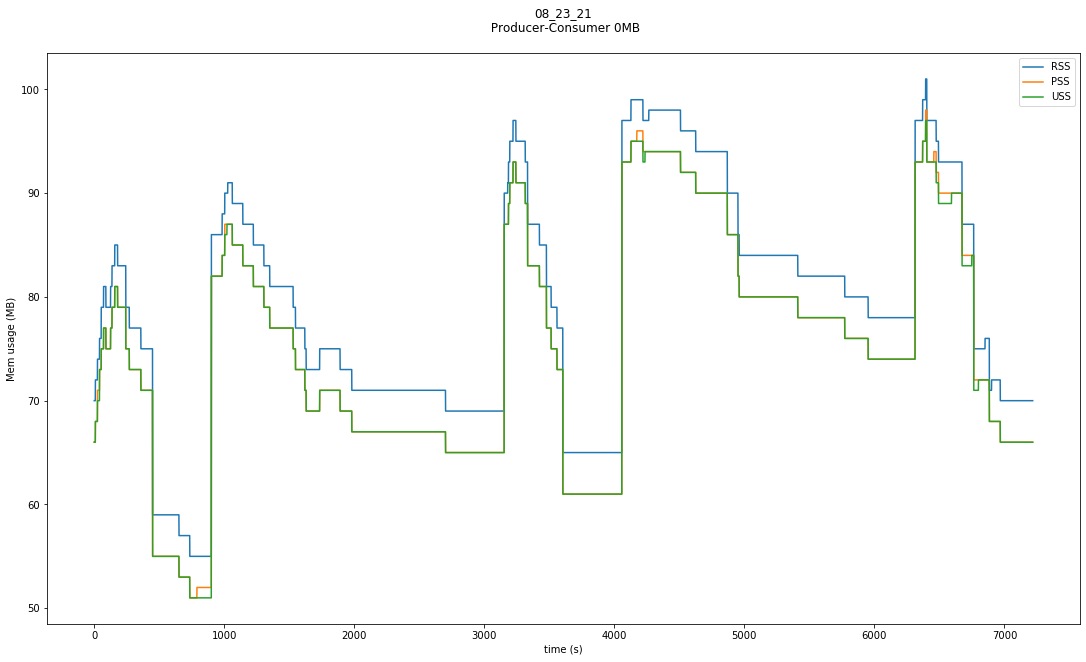

In [95]:
g.graph_memory_usage()

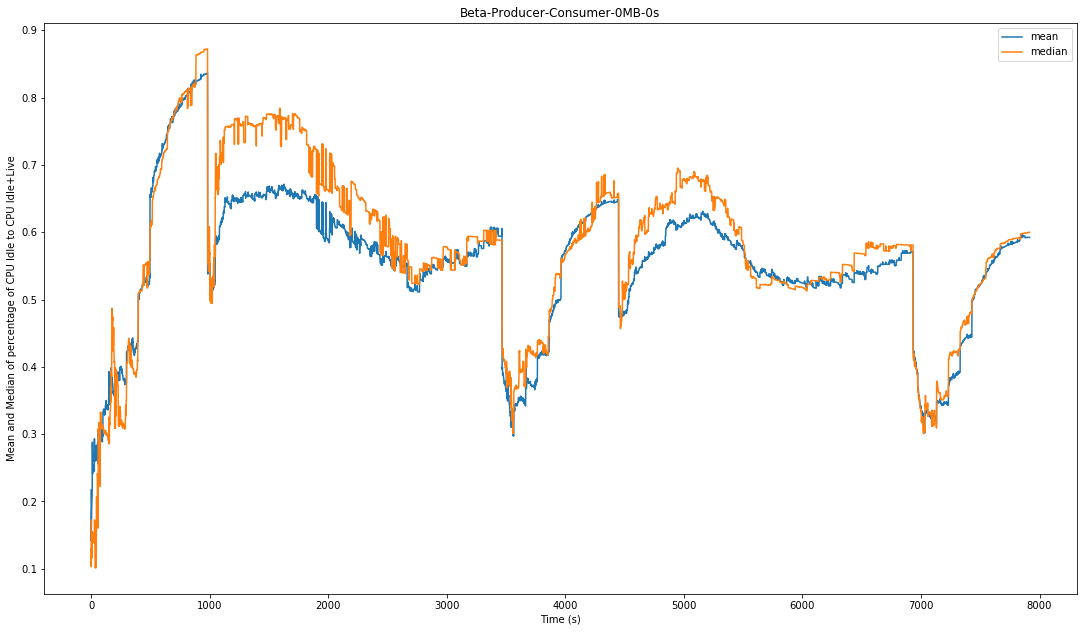

In [96]:
g.graph_mean_median_idle_percentage_timeseries()

Mean of means 0.47972065703990563


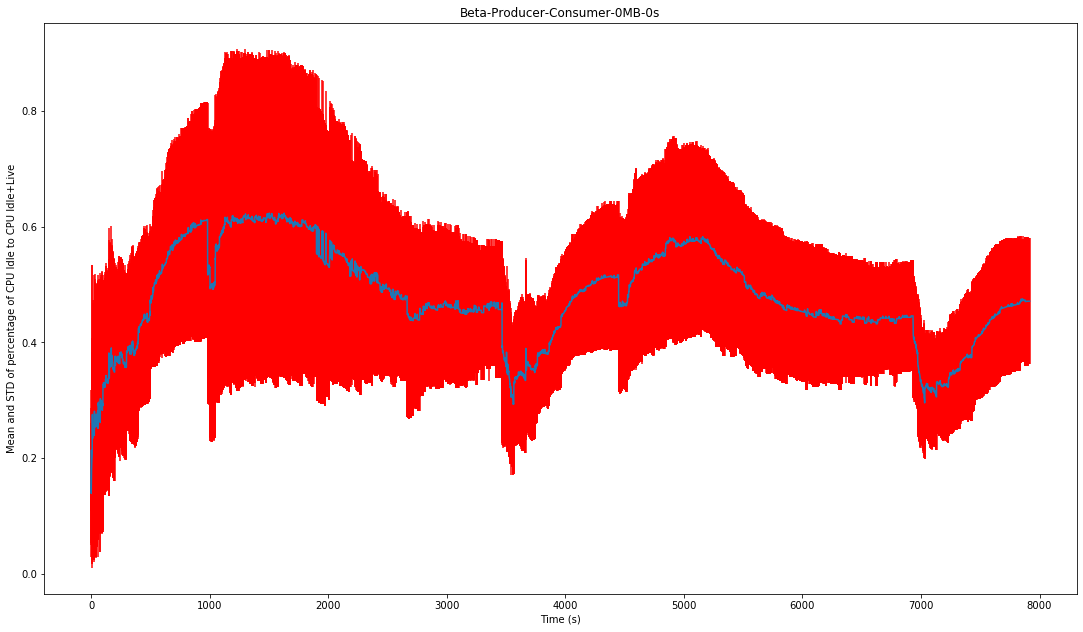

In [97]:
g.graph_mean_std_idle_percentage_timeseries()

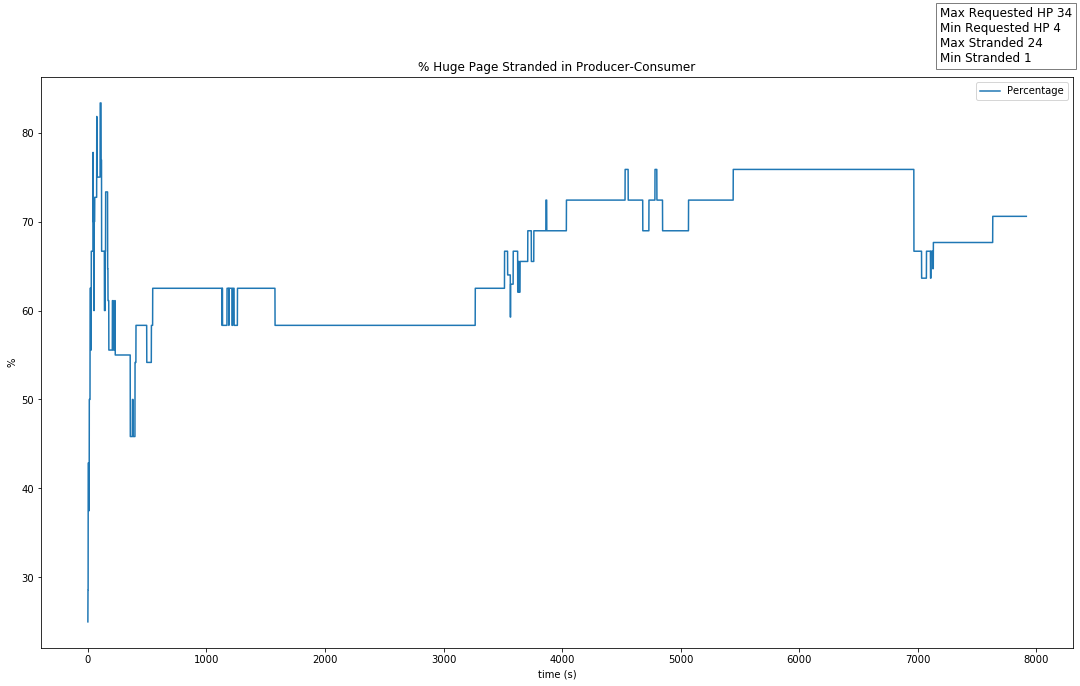

In [98]:
g.plot_stranded_percentage()

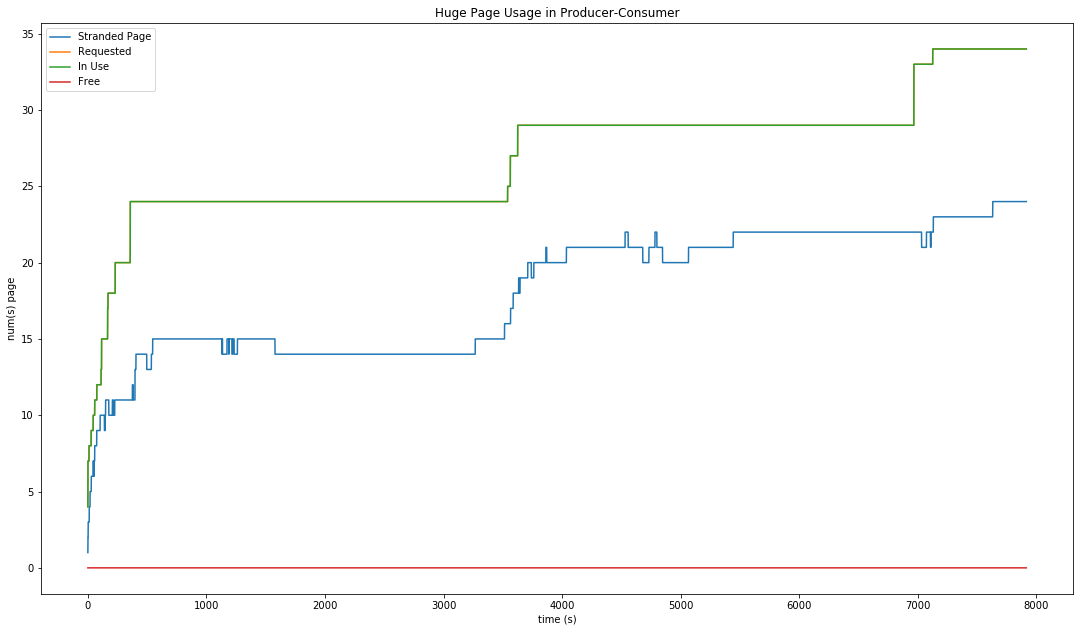

In [99]:
g.plot_hugepage_usage()

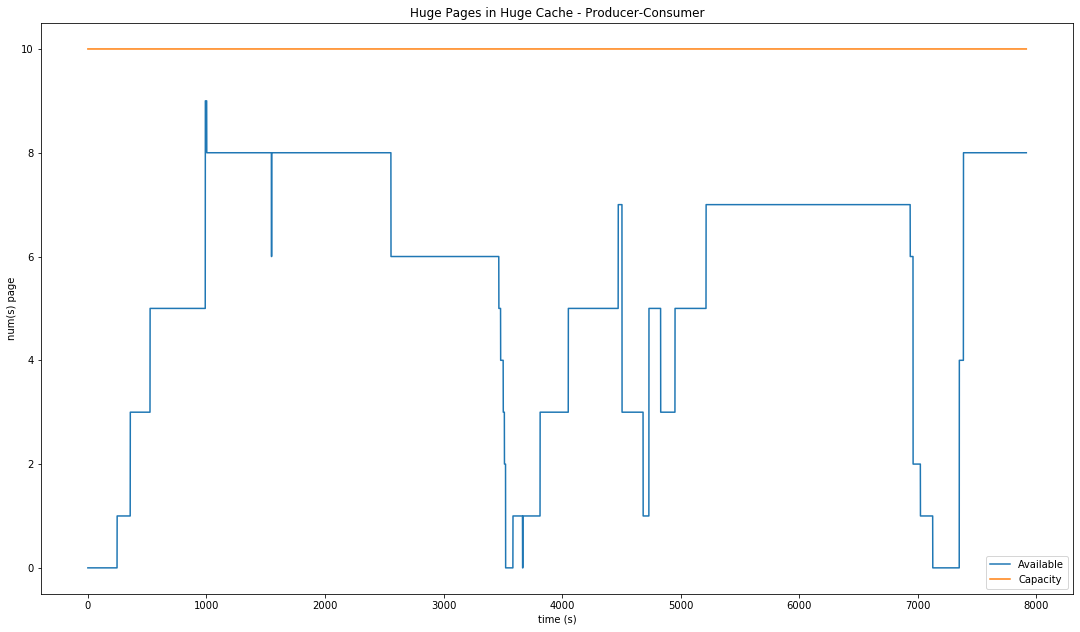

In [100]:
g.plot_huge_cache()

### Beta - 0MB - 5s
* Profile: Beta
* Release rate: 0MB
* Every 5 seconds, iterate through the hugepages and decide whether to drain cpu cache.

In [101]:
test_suite="minh-custom-bench"
tests=["Producer-Consumer"]
release_rates=["0MB"]
directory="/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/"
profile_name="Beta"
drain_check_cycle="5s"

In [102]:
g = GraphHugePageStats(directory, test_suite=test_suite, test=tests[0], release_rates=release_rates[0],
                       profile=profile_name, drain_check_cycle=drain_check_cycle)

/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/stats_storage/Beta/Producer-Consumer/0MB/5s


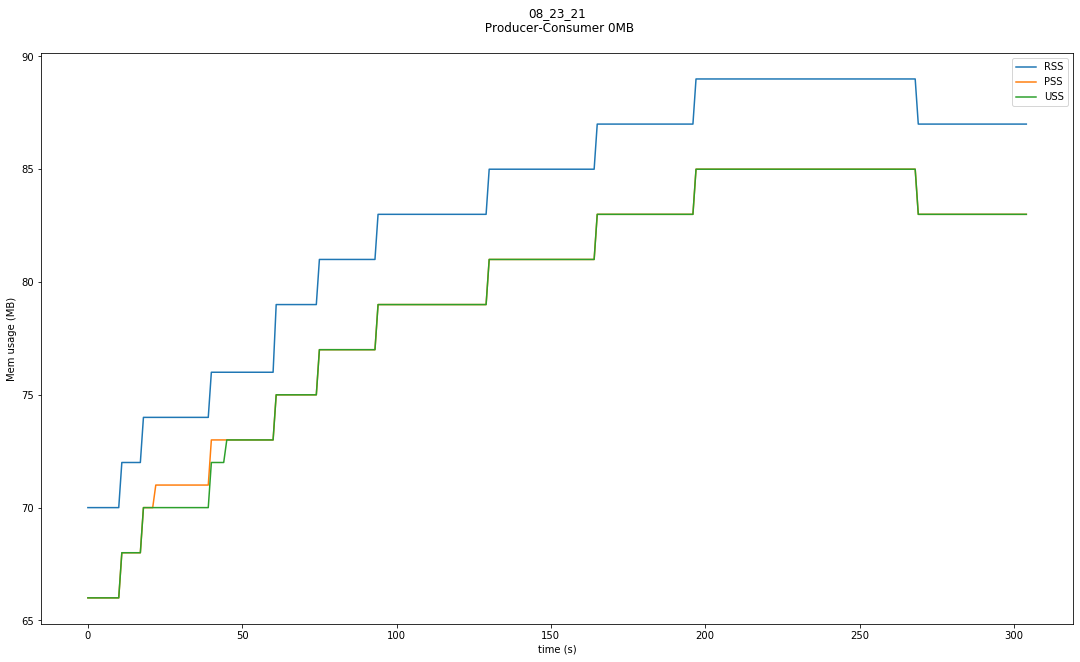

In [103]:
g.graph_memory_usage()

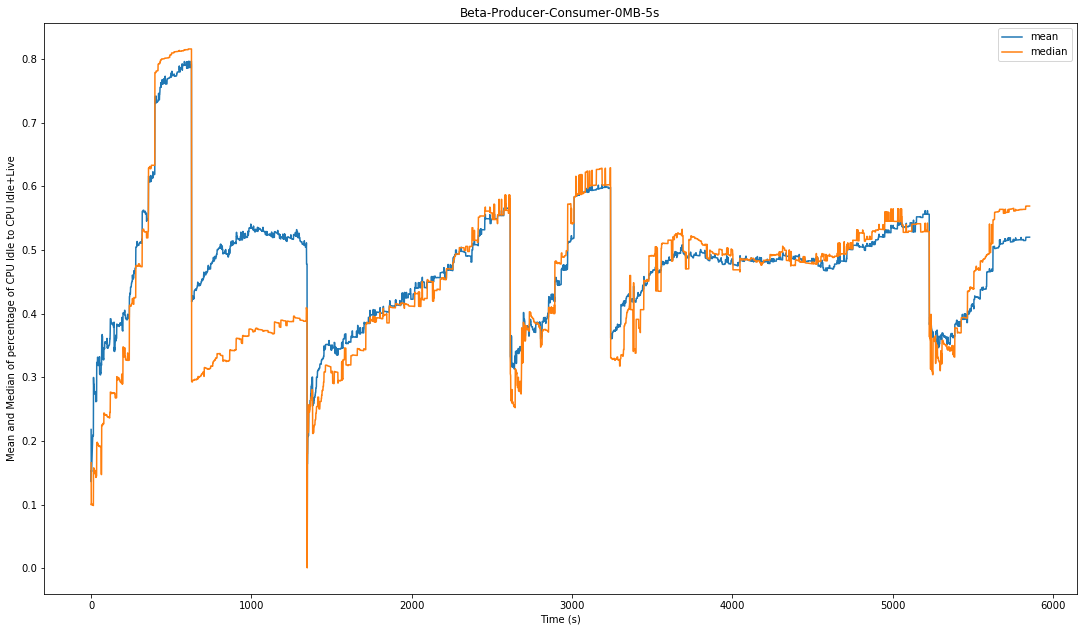

In [104]:
g.graph_mean_median_idle_percentage_timeseries()

Mean of means 0.40315172251419107


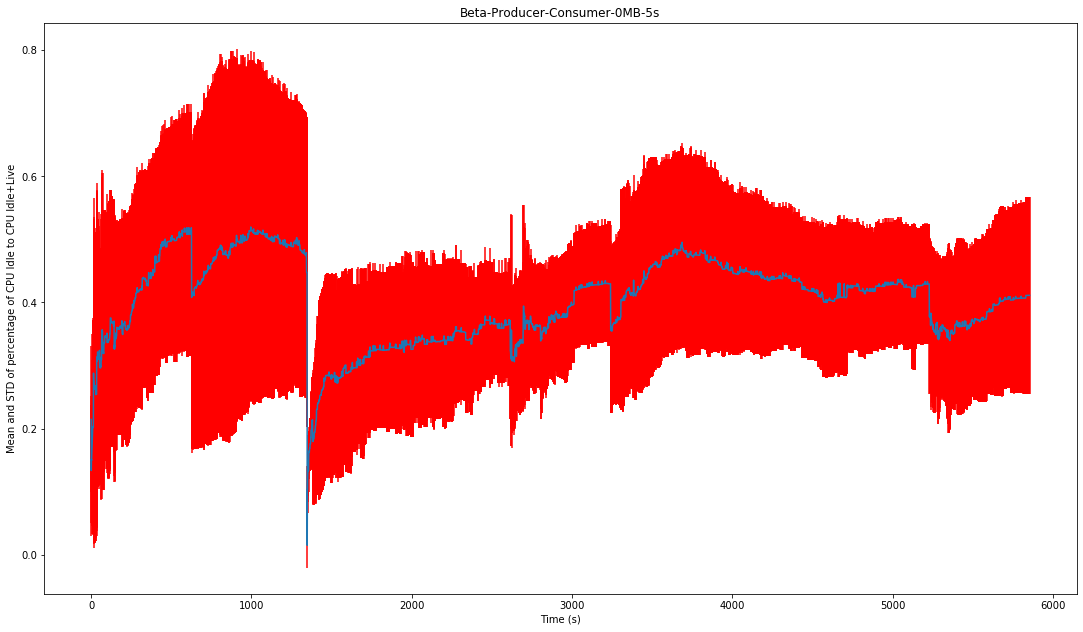

In [105]:
g.graph_mean_std_idle_percentage_timeseries()

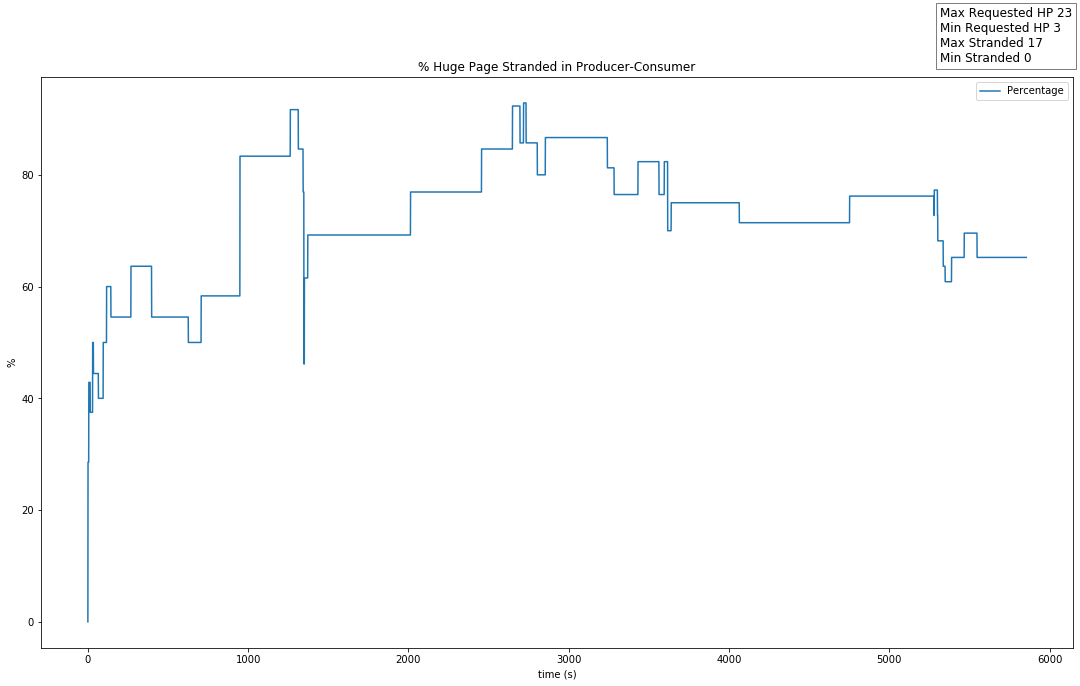

In [106]:
g.plot_stranded_percentage()

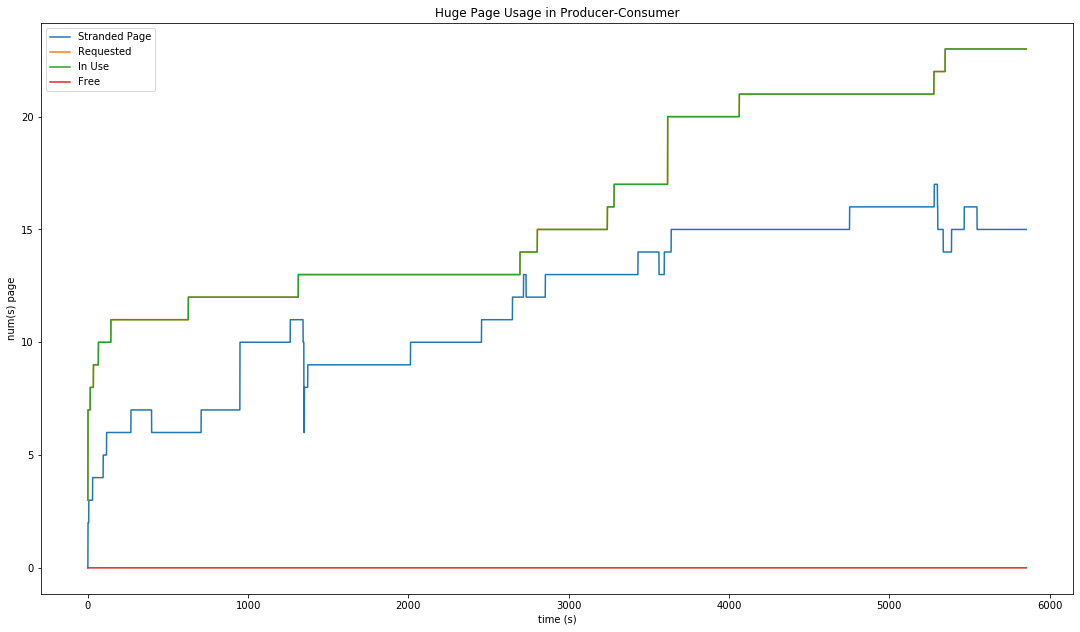

In [107]:
g.plot_hugepage_usage()

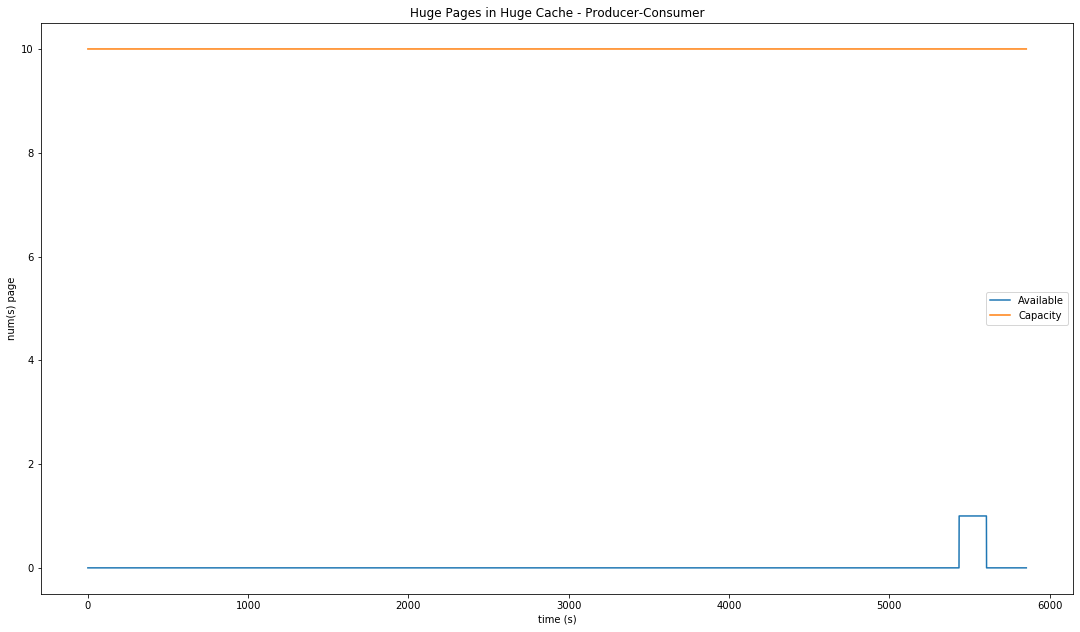

In [108]:
g.plot_huge_cache()

### Beta - 1MB - 0s
* Profile: Beta
* Release rate: 1MB
* We do not drain the cpu cache

In [1]:
test_suite="minh-custom-bench"
tests=["Producer-Consumer"]
release_rates=["1MB"]
directory="/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/"
profile_name="Beta"
drain_check_cycle="0s"

In [110]:
g = GraphHugePageStats(directory, test_suite=test_suite, test=tests[0], release_rates=release_rates[0],
                       profile=profile_name, drain_check_cycle=drain_check_cycle)

/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/stats_storage/Beta/Producer-Consumer/1MB/5s


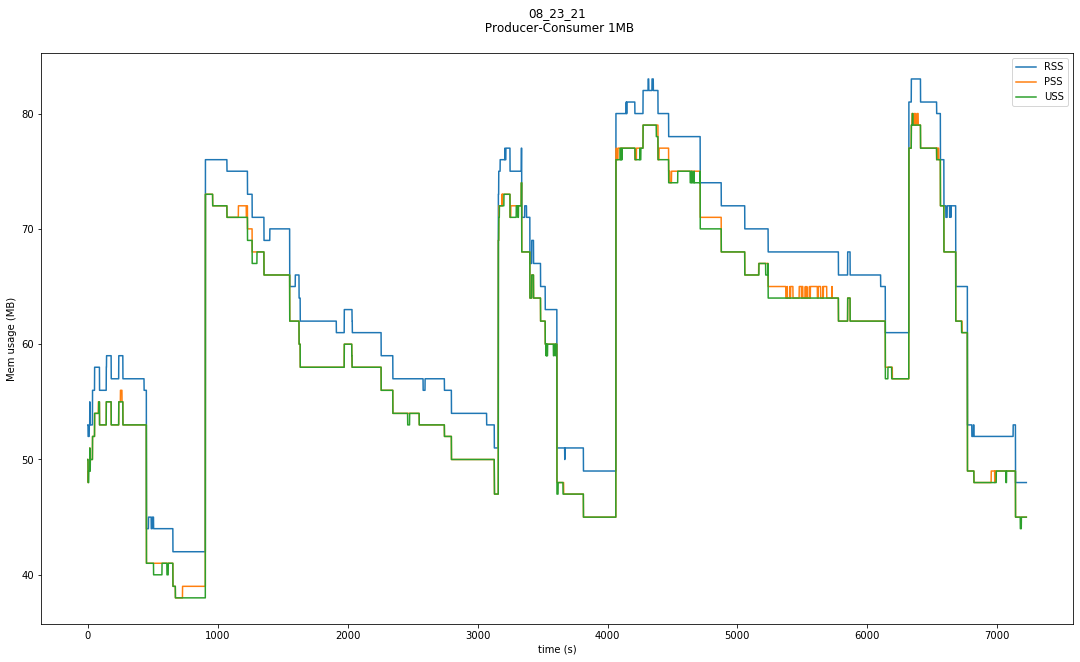

In [111]:
g.graph_memory_usage()

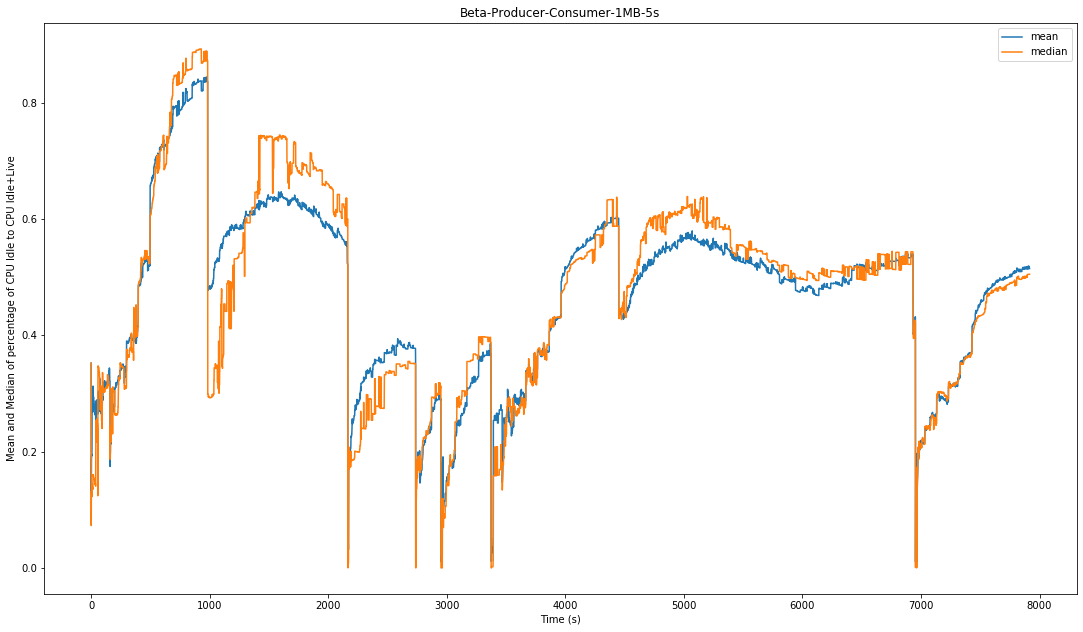

In [112]:
g.graph_mean_median_idle_percentage_timeseries()

Mean of means 0.39652253385177505


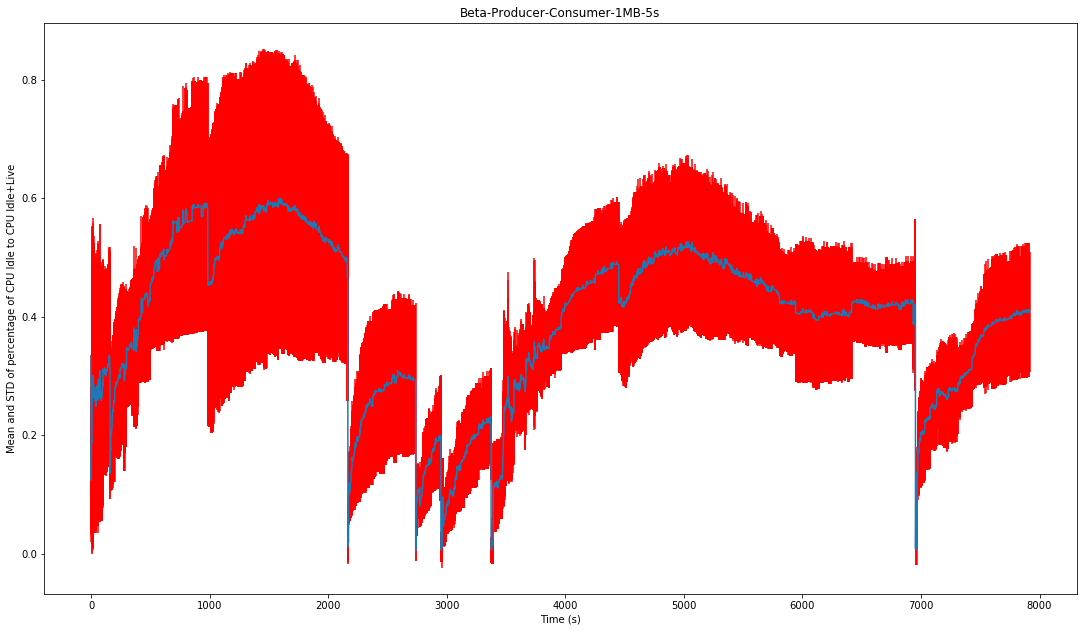

In [113]:
g.graph_mean_std_idle_percentage_timeseries()

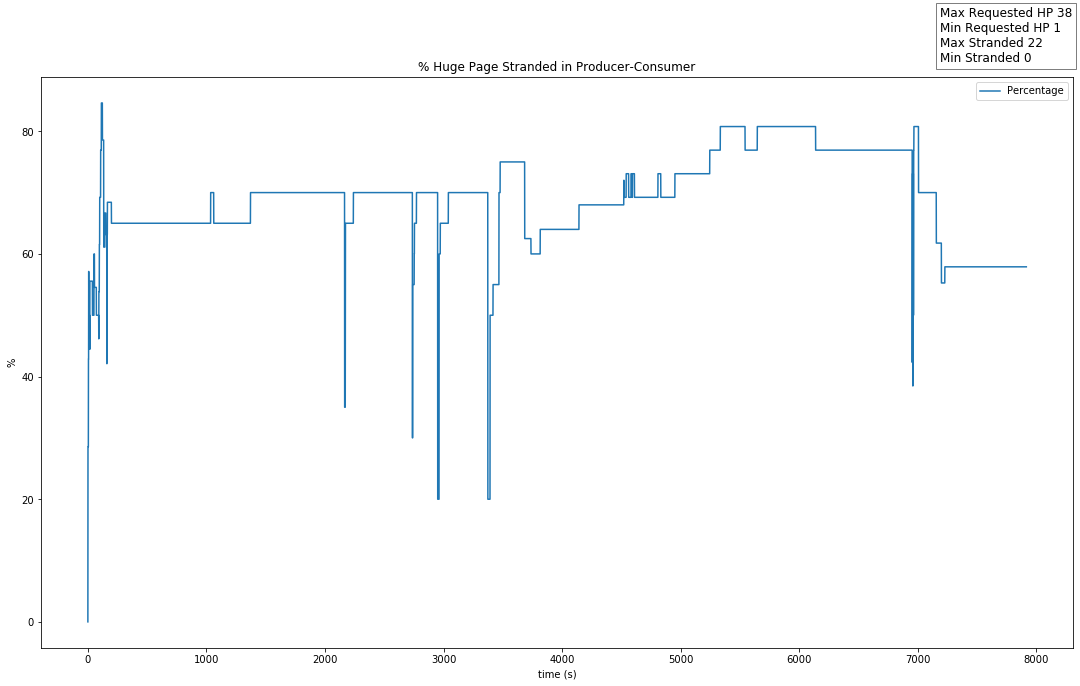

In [114]:
g.plot_stranded_percentage()

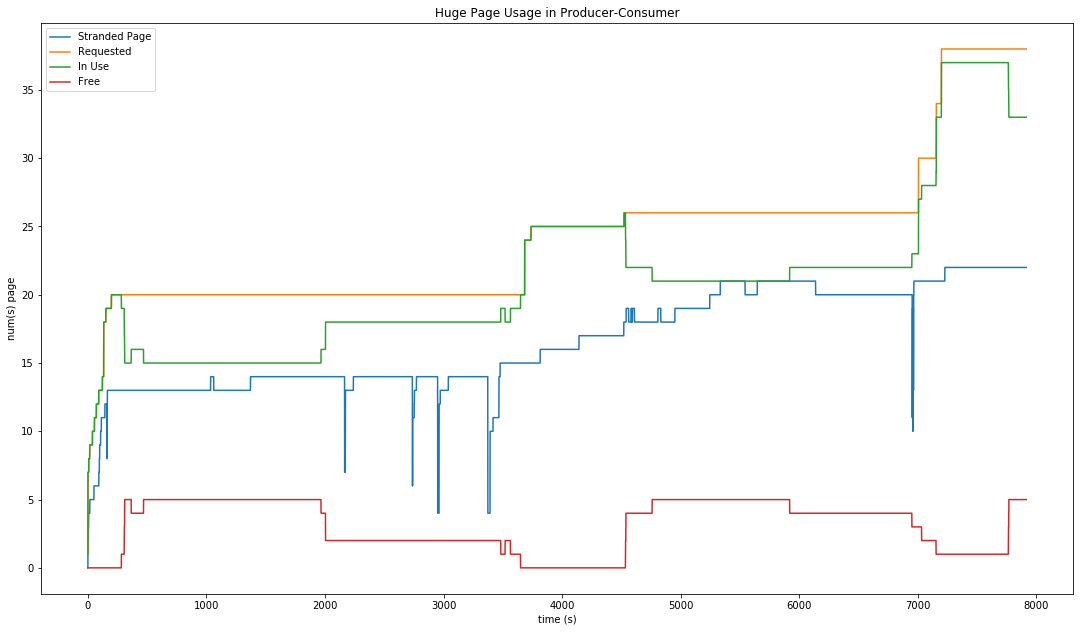

In [115]:
g.plot_hugepage_usage()

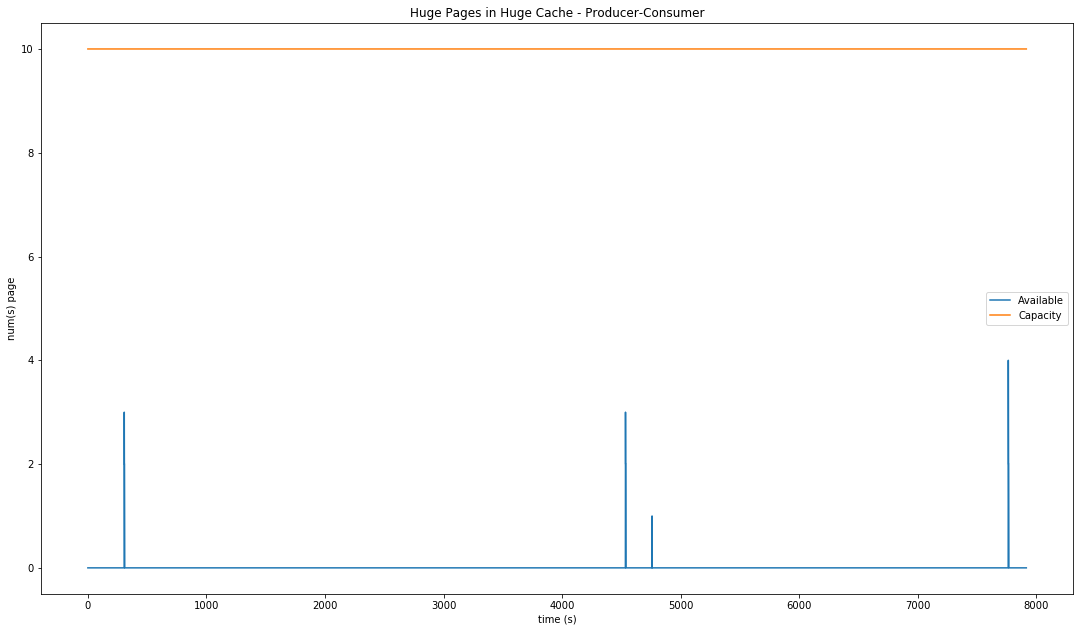

In [116]:
g.plot_huge_cache()

### Beta - 1MB - 5s
* Profile: Beta
* Release rate: 1MB
* Every 5 seconds, iterate through the hugepages and decide whether to drain cpu cache.

In [109]:
test_suite="minh-custom-bench"
tests=["Producer-Consumer"]
release_rates=["1MB"]
directory="/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/"
profile_name="Beta"
drain_check_cycle="5s"

In [110]:
g = GraphHugePageStats(directory, test_suite=test_suite, test=tests[0], release_rates=release_rates[0],
                       profile=profile_name, drain_check_cycle=drain_check_cycle)

/home/grads/t/tiendat.ng.cs/Documents/github_repos/tcmalloc/benchmarks/minh-custom-bench/stats_storage/Beta/Producer-Consumer/1MB/5s


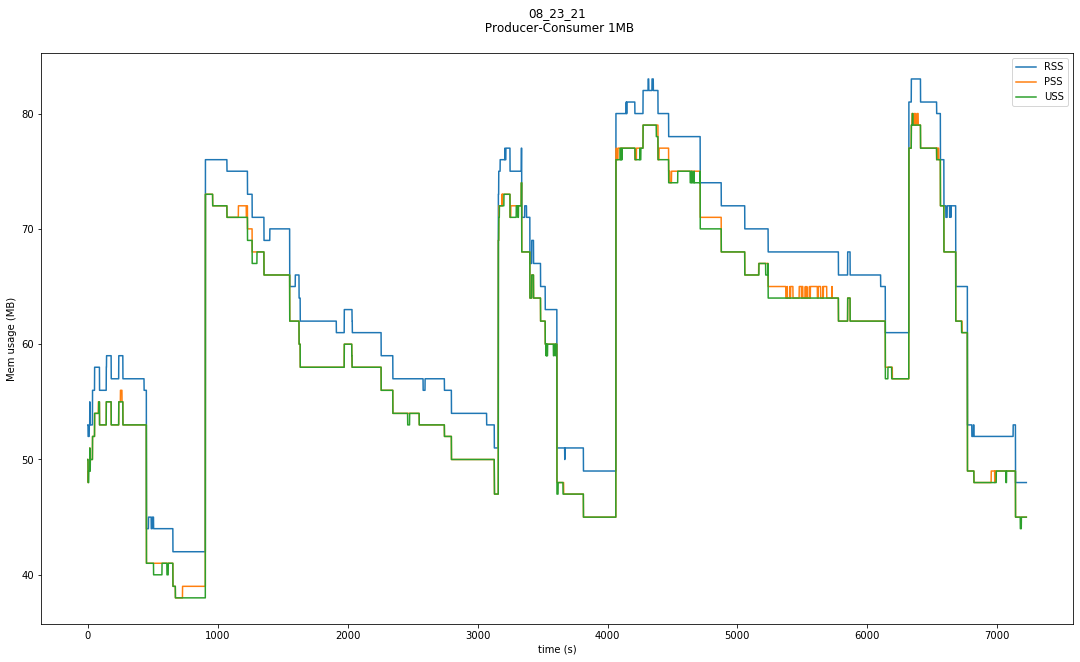

In [111]:
g.graph_memory_usage()

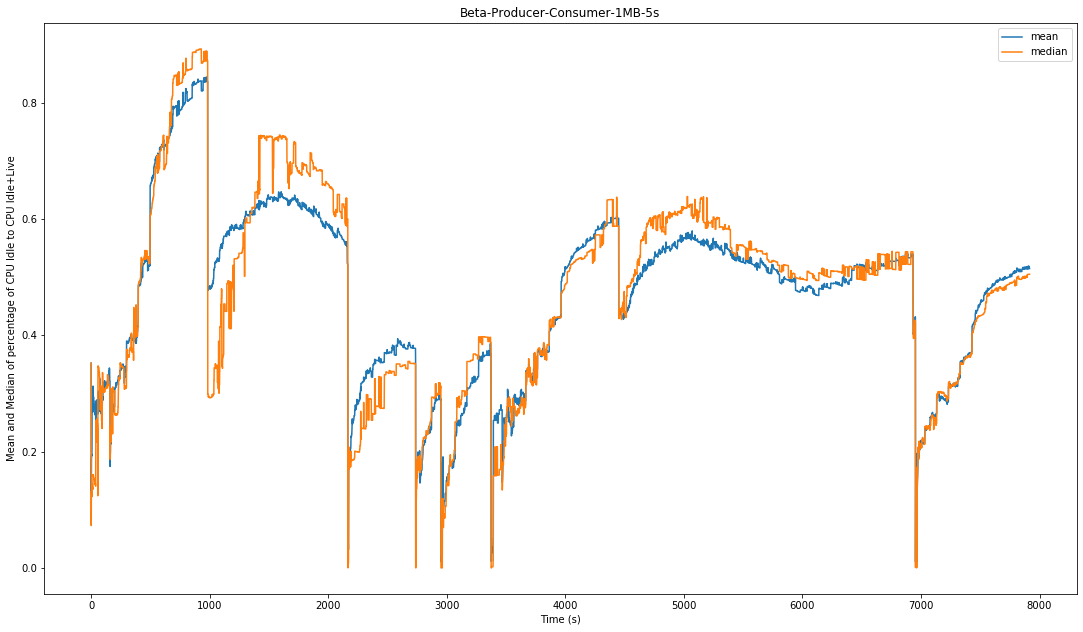

In [112]:
g.graph_mean_median_idle_percentage_timeseries()

Mean of means 0.39652253385177505


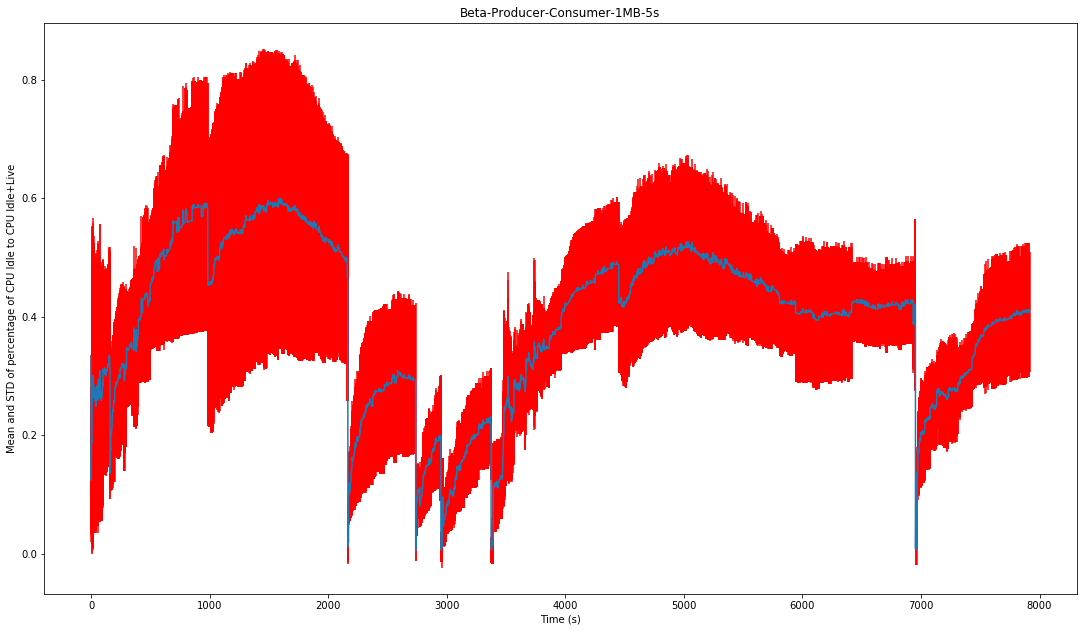

In [113]:
g.graph_mean_std_idle_percentage_timeseries()

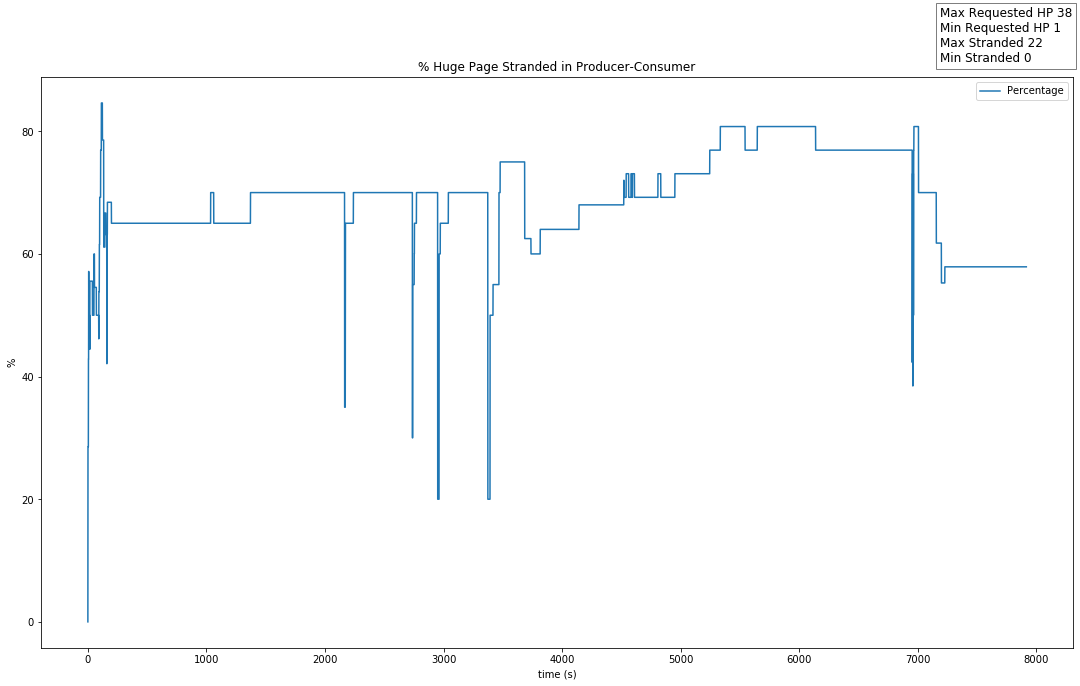

In [114]:
g.plot_stranded_percentage()

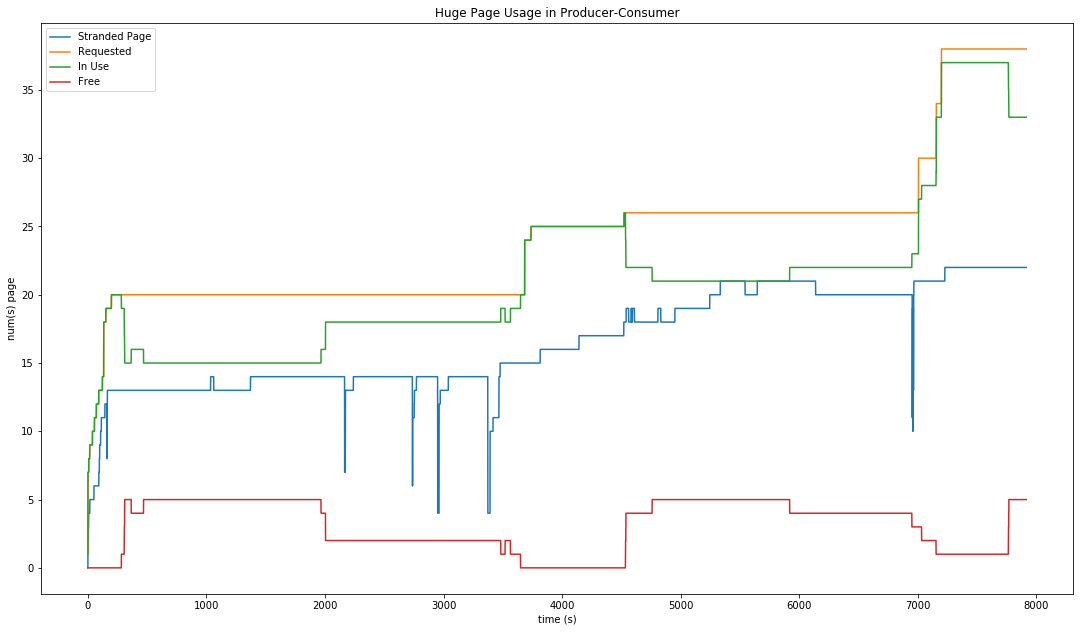

In [115]:
g.plot_hugepage_usage()

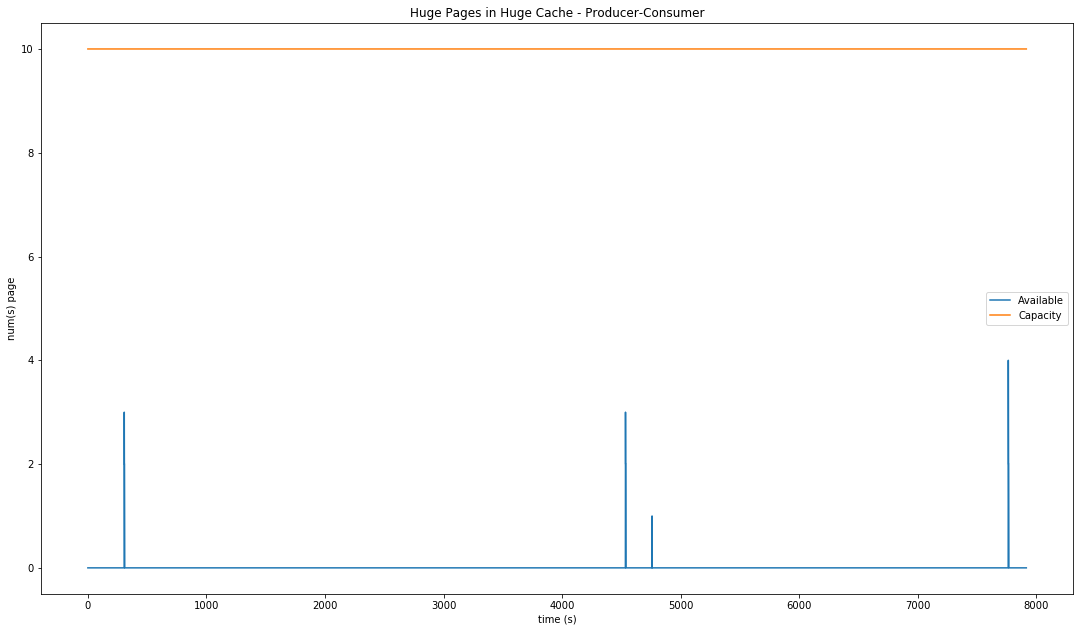

In [116]:
g.plot_huge_cache()